In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('../data/crc_clin_pub.csv', index_col=0)
data.head()

,race_ethnicity,naaccr_sex_code,n_cpt_pt,age_dx,ca_grade,institution,stage_dx,stage_dx_iv,ca_path_group_stage,ca_path_t_stage,...,ca_crc_crm,ca_crc_peri_inv,crc_type,PFS,OS,OS_time,Histology Category,Histology,Derived Grade or Differentiation of Tumor,CEA
record_id,,,,,,,,,,,,,,,,,,,,,
GENIE-DFCI-000048,Non-Hispanic White,Male,1,59,II,DFCI,Stage II,Stage I-III,NaN,NaN,...,1.0,Perineural invasion present,Right colon,NaN,0,324,Adenocarcinoma,"Adenocarcinoma, NOS",II,0.0
GENIE-DFCI-000147,Non-Hispanic White,Female,2,50,II,DFCI,Stage II,Stage I-III,NaN,NaN,...,1.0,Not present/unknown,Rectal,1.0,1,1235,Adenocarcinoma,"Adenocarcinoma, NOS",II,2.8
GENIE-DFCI-000233,Non-Hispanic White,Female,1,47,II,DFCI,Stage III,Stage I-III,III,T1,...,1.0,Not present/unknown,Rectal,1.0,1,3303,Adenocarcinoma,"Adenocarcinoma, NOS",II,1.0
GENIE-DFCI-000247,Non-Hispanic White,Female,1,63,I,DFCI,Stage IV,Stage IV,NaN,NaN,...,-1.0,Not present/unknown,Rectal,1.0,1,1163,Adenocarcinoma,"Adenocarcinoma, NOS",I,NaN
GENIE-DFCI-000306,Non-Hispanic White,Female,1,55,II,DFCI,Stage IV,Stage IV,NaN,NaN,...,1.0,Not present/unknown,Right colon,1.0,1,1230,Adenocarcinoma,"Adenocarcinoma, NOS",II,0.7


In [3]:
preds = pd.read_csv('../results/preds/preds_crc_ib_mut_act_rf_OS_comb_060623.csv', index_col=0)
preds = preds[['pred_prob_quart']]
preds.head()

,pred_prob_quart
GENIE-DFCI-000971,1
GENIE-DFCI-001038,3
GENIE-DFCI-002499,3
GENIE-DFCI-002507,3
GENIE-DFCI-002561,2


In [4]:
data['pred_prob_quart'] = np.NaN
data.loc[preds.index, 'pred_prob_quart'] = preds['pred_prob_quart']
data['pred_prob_quart'].value_counts()

pred_prob_quart
1.0    35
2.0    34
3.0    33
0.0    32
Name: count, dtype: int64

In [5]:
keep = ['pred_prob_quart', 'OS_time', 'OS']

<Axes: >

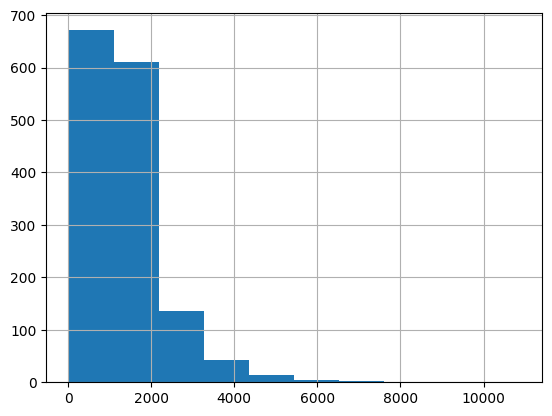

In [6]:
data['OS_time'].hist()

<Axes: >

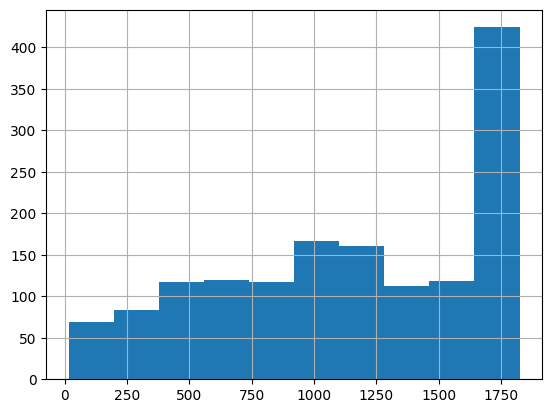

In [7]:
#limit to 5-year survival
data.loc[data['OS_time'] > 1825, 'OS_time'] = 1825
data['OS_time'].hist()

In [8]:
#get a list of time thresholds, 1-1825 days
time_thresh = [i for i in range(1, 1825)]

In [9]:
#make an empty dataframe to hold the results
km_1 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
#original number of patients
n_patients = data.shape[0]
#probability of survival
prob_survival = 1

for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data[(data['OS_time'] == t) & (data['OS'] == 0)].shape[0]
    #number of patients who died at this time point
    n_died = data[(data['OS_time'] == t) & (data['OS'] == 1)].shape[0]
    #calculate the percent of patients who died at time t, and subtract from 1 to get the probability of survival
    try:
        prob_survival = prob_survival * (1 - n_died/n_patients)
    except:
        prob_survival = 0
    perc_died = n_died/n_patients
    #add the results to the dataframe
    km_1 = pd.concat([km_1, pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_died', 'prob_survival'])], axis=0)
    #update the number of patients by removing those who died
    n_patients = n_patients - n_died
km_1.head()

,time,n_patients,n_died,prob_survival
0,1,1485,0,1.0
0,2,1485,0,1.0
0,3,1485,0,1.0
0,4,1485,0,1.0
0,5,1485,0,1.0


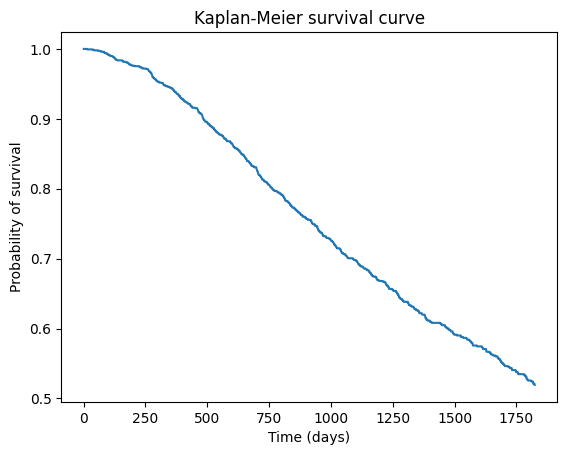

In [10]:
#plot the results
plt.plot(km_1['time'], km_1['prob_survival'])
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.title('Kaplan-Meier survival curve')
plt.show()

In [11]:
data['pred_prob_quart'].value_counts(dropna=False)

pred_prob_quart
NaN    1351
1.0      35
2.0      34
3.0      33
0.0      32
Name: count, dtype: int64

In [12]:
data = data.dropna(subset=['pred_prob_quart'])

In [13]:
pred_quart_values = [i for i in data['pred_prob_quart'].unique() if i not in ('Stage I-III NOS', np.NaN)]

In [14]:
data_stage = {}
km_stage = {}
for stage in pred_quart_values:
    data_stage[stage] = data[data['pred_prob_quart'] == stage]
    km_stage[stage] = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
    n_patients = data_stage[stage].shape[0]
    prob_survival = 1
    for t in time_thresh:
        n_patients = n_patients - data_stage[stage][(data_stage[stage]['OS_time'] == t) & (data_stage[stage]['OS'] == 0)].shape[0]
        n_died = data_stage[stage][(data_stage[stage]['OS_time'] == t) & (data_stage[stage]['OS'] == 1)].shape[0]
        try:
            prob_survival = prob_survival * (1 - n_died/n_patients)
        except:
            prob_survival = 0
        try:
            perc_died = n_died/n_patients
        except:
            perc_died = 0
        km_stage[stage] = pd.concat([km_stage[stage], pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_died', 'prob_survival'])], axis=0)
        n_patients = n_patients - n_died

In [15]:
import seaborn as sns
cmap = sns.color_palette('mako', n_colors=4)
colors = {0.0: cmap[0], 1.0: cmap[1], 2.0: cmap[2], 3.0: cmap[3]}

In [16]:
km_stage.keys()

dict_keys([1.0, 3.0, 2.0, 0.0])

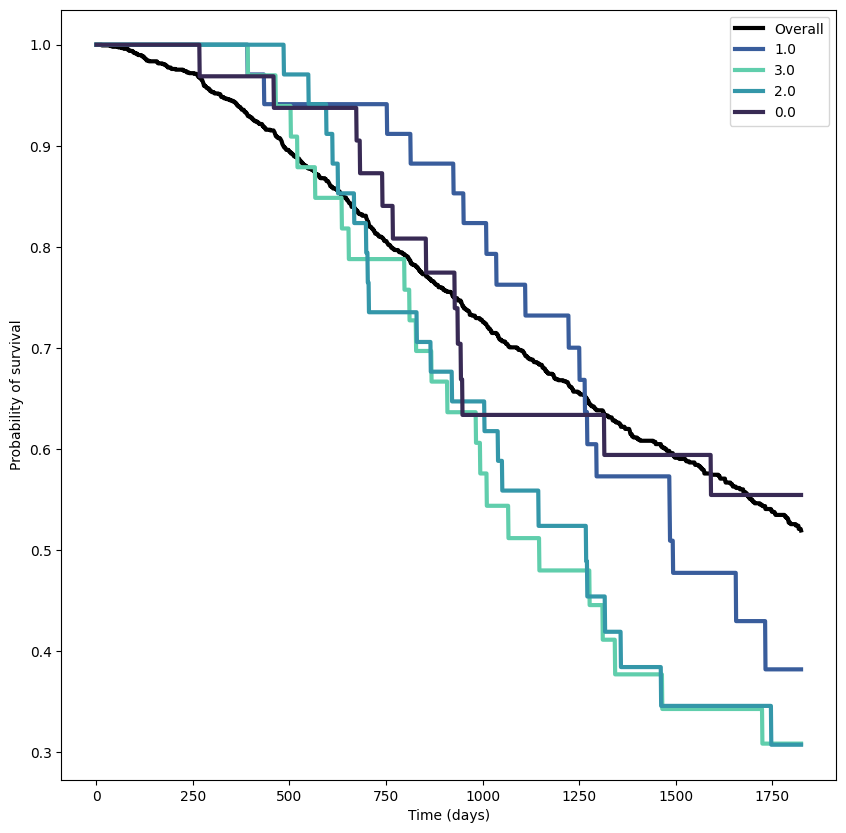

In [17]:
#plot the survival curves for the overall population and each stage on the same plot
plt.figure(figsize=(10,10))
plt.plot(km_1['time'], km_1['prob_survival'], label='Overall', color='black', linewidth=3)
for stage in km_stage.keys():
    #make the lines thicker
    plt.plot(km_stage[stage]['time'], km_stage[stage]['prob_survival'], label=stage, color=colors[stage], linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.savefig('../results/figures/km.png', dpi=300, bbox_inches='tight')